# Capstone Project

## Introduction

In this project, I will explore the relationship between location data and number of COVID-19 cases. Using San Francisco as an example, I will first explore the types of different neighborhoods in San Francisco. Then, I will investigate whether different types of neighborhoods have any connection with the number of COVID-19 cases. As the COVID-19 pandemic escalates in the whole world, the results from this project might be potentially helpful to medical researchers, policy makers, and the general public. On the one hand, people need to understand the means by which the virus has been spreading. On the other hand, it provides information about which areas might have high exposure risk to the virus that people should avoid.

I will use data from three sources in this project. First, the rate of COVID-19 cases by census zip code in San Francisco. This dataset gives me the number of confirmed cases in San Francisco by zip code and normalized by 2017 American Community Survey (ACS) 5-year estimates for population data to calculate rate per 10,000 residents. Second, the latitude and longitude of US zip codes. With information from this zipcode, I will pull data from the FourSquare API for the zip codes. Then the venues from the zip codes will be analyzed and clustered into different types of neighborhoods. Finally, I will look into the association between clusters of neighborhoods and number of COVID-19 cases. 

## Data

I will use data from three sources in this project. First, I got the rate of COVID-19 cases by census zip code in San Francisco from the DataSF website. This dataset gives me the number of confirmed cases in San Francisco by zip code and normalized by 2017 American Community Survey (ACS) 5-year estimates for population data to calculate rate per 10,000 residents. Second, the latitude and longitude of US zip codes. With information from this zipcode, I will pull data from the FourSquare API for the zip codes. Then the venues from the zip codes will be analyzed and clustered into different types of neighborhoods. Finally, I will look into the association between clusters of neighborhoods and number of COVID-19 cases. The two datasets can be found below:

- [COVID-19 cases by zip code in San Francisco](https://data.sfgov.org/COVID-19/Rate-of-COVID-19-Cases-by-Census-ZIP-Code-Tabulati/favi-qct6)

- [Geo-coordinates for US zip codes](https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/table/)

## Methodology

In this section, I will describe the methods that are used to analyze the data and achieve the goal of this project. First, I load a few packages that will be useful in exploring the data:

In [50]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt  

Then import the two datasets I will be using for this project:

In [16]:
covid = pd.read_csv('Rate_of_COVID-19_Cases_by_Census_ZIP_Code_Tabulation_Area.csv')
covid.rename(columns={'ZIP Code': 'Zip'}, inplace = True)
covid.head(5)

,Data as of,OBJECTID,Zip,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Rate Groups,Count of San Francisco Confirmed Cases,Estimated 2017 ACS San Francisco Population,Estimated Rate of San Francisco Cases per 10k,Case Rate Difference from San Francisco,multipolygon
0,2020/05/08,2,94121,34.0,43638,7.79,5-10,1891,864263,21.88,-14.09,MULTIPOLYGON (((-122.48542599984555 37.7898249...
1,2020/05/08,4,94123,28.0,25461,11.00,10-15,1891,864263,21.88,-10.88,MULTIPOLYGON (((-122.45005999994794 37.8024729...
2,2020/05/08,13,94158,18.0,6547,27.49,25-30,1891,864263,21.88,5.61,MULTIPOLYGON (((-122.3836959998312 37.75470099...
3,2020/05/08,18,94107,115.0,29920,38.44,35-40,1891,864263,21.88,16.56,MULTIPOLYGON (((-122.38530302568738 37.7898378...
4,2020/05/08,1,94118,31.0,41417,7.48,5-10,1891,864263,21.88,-14.40,MULTIPOLYGON (((-122.44767900001601 37.7917029...


In [13]:
coords = pd.read_csv('us-zip-code-latitude-and-longitude.csv')
coords.head(5)

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,71937,Cove,AR,34.398483,-94.39398,-6,1,34.398483
1,72044,Edgemont,AR,35.624351,-92.16056,-6,1,35.624351
2,56171,Sherburn,MN,43.660847,-94.74357,-6,1,43.660847
3,49430,Lamont,MI,43.010337,-85.89754,-5,1,43.010337
4,52585,Richland,IA,41.194129,-91.98027,-6,1,41.194129


Then, I merge the two datasets and keep only the zip codes in both datasets, and removed zip codes with blank confirmed cases:

In [34]:
df = pd.merge(left = covid, right = coords)
df = df[np.isnan(df['Count of Confirmed Cases']) == False]
df.head(5)

,Data as of,OBJECTID,Zip,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Rate Groups,Count of San Francisco Confirmed Cases,Estimated 2017 ACS San Francisco Population,Estimated Rate of San Francisco Cases per 10k,Case Rate Difference from San Francisco,multipolygon,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,2020/05/08,2,94121,34.0,43638,7.79,5-10,1891,864263,21.88,-14.09,MULTIPOLYGON (((-122.48542599984555 37.7898249...,San Francisco,CA,37.778729,-122.49265,-8,1,37.778729
1,2020/05/08,4,94123,28.0,25461,11.00,10-15,1891,864263,21.88,-10.88,MULTIPOLYGON (((-122.45005999994794 37.8024729...,San Francisco,CA,37.801028,-122.43836,-8,1,37.801028
2,2020/05/08,18,94107,115.0,29920,38.44,35-40,1891,864263,21.88,16.56,MULTIPOLYGON (((-122.38530302568738 37.7898378...,San Francisco,CA,37.766529,-122.39577,-8,1,37.766529
3,2020/05/08,1,94118,31.0,41417,7.48,5-10,1891,864263,21.88,-14.40,MULTIPOLYGON (((-122.44767900001601 37.7917029...,San Francisco,CA,37.782029,-122.46158,-8,1,37.782029
4,2020/05/08,27,94117,48.0,43610,11.01,10-15,1891,864263,21.88,-10.87,MULTIPOLYGON (((-122.42992899967089 37.7779089...,San Francisco,CA,37.770937,-122.44276,-8,1,37.770937


Then, I use FourSquare to get venues near these zip codes:

In [56]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [58]:
CLIENT_ID = '2PATX5OVWCHMEO0HRZ3OXSTVJVVTUV4EVEHZGFN2KKYPGHQI' # your Foursquare ID
CLIENT_SECRET = 'UNIJA3LTM5DYJMQGD4ZD3BLJUTPDMJ2KTGWDY1DP5ZNEJ1TD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100
radius = 50

df_venues = getNearbyVenues(names=df['Zip'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

94121
94123
94107
94118
94117
94116
94115
94109
94114
94112
94110
94105
94103
94132
94102
94133
94134
94122
94124
94127
94131


In [ ]:
Then, I perform one hot coding to the venues:

In [59]:
# one hot encoding
df_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_onehot['Neighborhood'] = df_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [df_onehot.columns[-1]] + list(df_onehot.columns[:-1])
df_onehot = df_onehot[fixed_columns]

df_grouped = df_onehot.groupby('Neighborhood').mean().reset_index()
df_grouped

,Neighborhood,ATM,Accessories Store,Adult Boutique,African Restaurant,Alternative Healer,American Restaurant,Antique Shop,Art Gallery,Art Museum,...,Trail,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,94102,0.000000,0.000000,0.000000,0.000000,0.000000,0.025974,0.000000,0.000000,0.012987,...,0.000000,0.000000,0.000000,0.000000,0.012987,0.000000,0.038961,0.012987,0.0000,0.000000
1,94103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026667,0.000000,0.0000,0.000000
2,94105,0.000000,0.000000,0.000000,0.000000,0.013333,0.013333,0.000000,0.040000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.013333,0.000000,0.000000,0.0000,0.013333
3,94107,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.066667,0.0000,0.000000
4,94109,0.000000,0.000000,0.000000,0.012500,0.000000,0.025000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.012500,0.037500,0.025000,0.012500,0.0125,0.012500
5,94110,0.000000,0.000000,0.000000,0.000000,0.000000,0.020408,0.000000,0.020408,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
6,94112,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.0000,0.000000
7,94114,0.000000,0.000000,0.013333,0.000000,0.000000,0.013333,0.000000,0.013333,0.000000,...,0.013333,0.000000,0.000000,0.000000,0.000000,0.000000,0.026667,0.013333,0.0000,0.026667
8,94115,0.000000,0.000000,0.000000,0.000000,0.000000,0.020202,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.020202,0.020202,0.000000,0.0000,0.020202
9,94116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.025000


Then the top 10 venues are stored into a data frame:

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [174]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = df_grouped['Neighborhood']

for ind in np.arange(df_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94102,Coffee Shop,Hotel,Café,Theater,Wine Bar,Beer Bar,Cocktail Bar,Concert Hall,Thai Restaurant,Park
1,94103,Nightclub,Cocktail Bar,Gay Bar,Food Truck,Motorcycle Shop,Thai Restaurant,Cosmetics Shop,Mexican Restaurant,Bar,Sushi Restaurant
2,94105,Coffee Shop,Food Truck,Café,Art Gallery,Gym,Gym / Fitness Center,Juice Bar,Burger Joint,Japanese Restaurant,New American Restaurant
3,94107,Wine Shop,Park,Café,Breakfast Spot,Coffee Shop,Deli / Bodega,Distillery,Sandwich Place,Rock Club,French Restaurant
4,94109,Grocery Store,Steakhouse,Gym / Fitness Center,Deli / Bodega,Coffee Shop,Vietnamese Restaurant,Pet Store,Chinese Restaurant,Diner,Bar


In order to find the optimal number of clusters for the data, I use the elbow method:

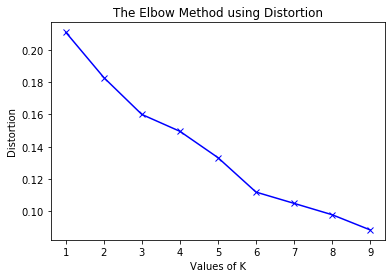

In [51]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10)
X = df_grouped.drop('Neighborhood', 1)
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

From the plot, it looks like the elbow point could be 3 or 6. To reserve the interpretability of the clusters, I choose to run k-means with 3 clusters:

In [129]:
# set number of clusters
kclusters = 3

df_grouped_clustering = df_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 
pd.Series(kmeans.labels_).value_counts()

1    18
2     2
0     1
dtype: int64

## Results

Now, the results for the clustering analysis are presented. I first merge the clustering results with the original dataset:

In [175]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)


In [188]:
df_merged = df

# merge df_grouped with toronto_data to add latitude/longitude for each neighborhood
df_merged.rename(columns={'ZIP': 'Neighborhood'}, inplace=True)
df_merged = df_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
df_merged['Neighborhood'] = df_merged['Neighborhood'].apply(str)
df_merged # check the last columns!


,Data as of,OBJECTID,Neighborhood,Count of Confirmed Cases,Estimated 2017 ACS Population,Estimated Rate of Cases per 10k,Rate Groups,Count of San Francisco Confirmed Cases,Estimated 2017 ACS San Francisco Population,Estimated Rate of San Francisco Cases per 10k,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2020/05/08,2,94121,34.0,43638,7.79,5-10,1891,864263,21.88,...,Café,Chinese Restaurant,American Restaurant,Pizza Place,Convenience Store,Japanese Restaurant,Music Store,Dessert Shop,Antique Shop,Pharmacy
1,2020/05/08,4,94123,28.0,25461,11.00,10-15,1891,864263,21.88,...,French Restaurant,Gym / Fitness Center,Sandwich Place,Park,Spa,Burger Joint,Salad Place,Taco Place,Coffee Shop,Thai Restaurant
2,2020/05/08,18,94107,115.0,29920,38.44,35-40,1891,864263,21.88,...,Wine Shop,Park,Café,Breakfast Spot,Coffee Shop,Deli / Bodega,Distillery,Sandwich Place,Rock Club,French Restaurant
3,2020/05/08,1,94118,31.0,41417,7.48,5-10,1891,864263,21.88,...,Bakery,Japanese Restaurant,Burmese Restaurant,Chinese Restaurant,Thai Restaurant,Wine Shop,Pizza Place,Vietnamese Restaurant,Pet Store,Yoga Studio
4,2020/05/08,27,94117,48.0,43610,11.01,10-15,1891,864263,21.88,...,Coffee Shop,Boutique,Park,Pizza Place,Thrift / Vintage Store,Liquor Store,Gastropub,Bookstore,Breakfast Spot,Playground
5,2020/05/08,26,94116,30.0,47708,6.29,5-10,1891,864263,21.88,...,Chinese Restaurant,Dumpling Restaurant,Café,Korean Restaurant,Light Rail Station,Liquor Store,Sandwich Place,Shoe Store,Spa,Bubble Tea Shop
6,2020/05/08,25,94115,117.0,35751,32.73,30-35,1891,864263,21.88,...,Bakery,Spa,Café,Cosmetics Shop,Pizza Place,Chinese Restaurant,Boutique,Salon / Barbershop,Bubble Tea Shop,New American Restaurant
7,2020/05/08,20,94109,87.0,56587,15.37,15-20,1891,864263,21.88,...,Grocery Store,Steakhouse,Gym / Fitness Center,Deli / Bodega,Coffee Shop,Vietnamese Restaurant,Pet Store,Chinese Restaurant,Diner,Bar
8,2020/05/08,24,94114,38.0,34561,11.00,10-15,1891,864263,21.88,...,Gay Bar,Thai Restaurant,Coffee Shop,Scenic Lookout,Yoga Studio,Clothing Store,Playground,Pet Store,Indian Restaurant,Deli / Bodega
9,2020/05/08,23,94112,231.0,85373,27.06,25-30,1891,864263,21.88,...,Mexican Restaurant,Pizza Place,Sandwich Place,Vietnamese Restaurant,Bus Station,Liquor Store,Fried Chicken Joint,Food Truck,Café,Cajun / Creole Restaurant


Then, I check the frequency of the clusters:

In [83]:
df_merged['Cluster Labels'].value_counts()

1    18
2     2
0     1
Name: Cluster Labels, dtype: int64

It looks like most zip codes are in cluster 1, and very few clusters fall in the other 2 clusters. So I further check the centroids of the clusters. Looks like Cluster 0 is near Chinese restaurants, dessert shop, playground, pharmacy, etc. Cluster 1 has a little bit of everything, and Cluster 2 is close to trail, garden, bus line, etc. 

In [136]:
centroids = pd.DataFrame(kmeans.cluster_centers_).transpose()
centroids.index = df_grouped.columns[1:]
centroids.columns = ('Cluster 0', 'Cluster 1', 'Cluster 2')
print(centroids.sort_values(by = ['Cluster 0'], ascending = False).head(10))
print(centroids.sort_values(by = ['Cluster 1'], ascending = False).head(10))
print(centroids.sort_values(by = ['Cluster 2'], ascending = False).head(10))

                    Cluster 0  Cluster 1  Cluster 2
Chinese Restaurant      0.250   0.021823        0.0
Dessert Shop            0.125   0.009525        0.0
Playground              0.125   0.011592        0.0
Pharmacy                0.125   0.011493        0.0
Café                    0.125   0.036026        0.0
Light Rail Station      0.125   0.004412        0.0
Shoe Store              0.125   0.003592        0.0
Office                  0.000   0.001852        0.0
Motorcycle Shop         0.000   0.002222        0.0
Music School            0.000   0.000722        0.0
                    Cluster 0  Cluster 1  Cluster 2
Coffee Shop             0.000   0.047331        0.0
Café                    0.125   0.036026        0.0
Mexican Restaurant      0.000   0.031244        0.0
Park                    0.000   0.029974        0.1
Pizza Place             0.000   0.028122        0.0
Bakery                  0.000   0.025447        0.0
Chinese Restaurant      0.250   0.021823        0.0
Sandwich Pla

Then, get ready for displaying clustering results on the map, with number of COVID-19 cases layered at the bottom:

In [202]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[37.773972, -122.431297], zoom_start=12)


In [196]:
import urllib.request, json 
with urllib.request.urlopen("https://data.sfgov.org/api/geospatial/favi-qct6?method=export&format=GeoJSON") as url:
    data = json.loads(url.read().decode())

In [203]:
map_clusters.choropleth(
    geo_data=data,
    data=df_merged,
    columns=['Neighborhood', 'Estimated Rate of Cases per 10k'],
    key_on='feature.properties.zip_code',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Estimated Rate of COVID-19 Cases per 10k in San Francisco'
)
map_clusters

In [201]:

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Neighborhood'], df_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Discussion

From the results I presented above, it can be seen that the majority of zip codes in San Francisco is homogeneous. The neighborhoods in San Francisco do not have many distinctive types. Most neighborhoods have all kinds of venues around them, which means San Francisco is in general a very convenient city to live in. It is also possible that the distinctive types of neighborhoods actually exist, but they are smaller than what a zip code covers. Exploring the zip codes and estimated rate of COVID-19 cases per 10k reveals that the relationship between the two might be very weak. From the map, it can be seen that there are more COVID-19 cases in the east side of San Francisco. However, there is no clear evidence that more cases are necessarily related to the zip code, or the venues around the area. It is likely that other factors might be associated with the high number of COVID-19 cases, such as population density. Further research is needed to provide evidence regarding other factors.  

## Conclusion

In this project, I used exploratory data analysis methods and machine learning methods, such as k-means, to explore the clustering of neighborhoods in San Francisco based on zip codes and the venues around the zip codes. Then, the relationship between the clusters and the number of COVID-19 cases per 10k population was investigated. No strong linkage was found between the clustering structure of the neighborhoods and the number of cases. 